In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    L2CurvesMetric,
    insert_zeros,
)

from load_data import create_graph, read_and_normalize_property_data, z_score_normalize
from utils import random_graph_sequence, plot_function, remove_undirected_edges, resample_curve, get_curve_from_graph, plot_curve
from metrics import get_SRVMetric_distance, get_L2_norm_two_curves

INFO: Using numpy backend


In [2]:

stone_ids = ['BT.1.4-25.','BT.1.A.','BT.1.C.','BT.1.F.','BT.2.65.','BT.2.UUU.']
filename = 'Melton_sequence_data_sample.xlsx'

dataset = pd.read_excel(filename, sheet_name='SAMPLE_DATA')
data_collection = read_and_normalize_property_data(dataset, stone_ids)

graphs = {}
for stone_id in stone_ids:
    G = create_graph(dataset, data_collection, stone_id)
    graphs[stone_id] = G
    
print(graphs['BT.1.4-25.'].nodes['BT.1.4-25.01']["surface"])
print(graphs['BT.1.4-25.'].nodes['BT.1.4-25.02']["surface"])
print(graphs['BT.1.4-25.'].nodes['BT.1.4-25.03']["surface"])
print(graphs['BT.1.4-25.'].nodes['BT.1.4-25.04']["surface"])
print(graphs['BT.1.4-25.'].nodes['BT.1.4-25.05']["surface"])

-0.9187717908724954
-0.6248690393435846
-0.3309662878146744
-0.037063536285763664
1.9116706543165174


In [3]:
k_sampling_points = 40

def get_resampled_geostats_curve(node_id, graphs, function, k_sampling_points):
    x, y = get_curve_from_graph(node_id, graphs, function)
    x_resample, y_resample = resample_curve(x, y, k_sampling_points=k_sampling_points)
    curve = gs.vstack((x_resample, y_resample)).T
    return curve

In [4]:
for id1 in stone_ids:
    for id2 in stone_ids:
        curve_a = get_resampled_geostats_curve(id1, graphs, "surface", k_sampling_points)
        curve_b = get_resampled_geostats_curve(id2, graphs, "surface", k_sampling_points)
        dist = get_SRVMetric_distance(curve_a, curve_b, k_sampling_points=k_sampling_points)
        distL2 = get_L2_norm_two_curves(curve_a.T[1],curve_b.T[1])
        print("SRV Dist between: ", id1, " and ", id2, " : ", dist)
        print("L2 Dist between: ", id1, " and ", id2, " : ", distL2)

SRV Dist between:  BT.1.4-25.  and  BT.1.4-25.  :  0.0
L2 Dist between:  BT.1.4-25.  and  BT.1.4-25.  :  0.0
SRV Dist between:  BT.1.4-25.  and  BT.1.A.  :  4.502107680392621
L2 Dist between:  BT.1.4-25.  and  BT.1.A.  :  7.235652723016694
SRV Dist between:  BT.1.4-25.  and  BT.1.C.  :  3.8954813829106985
L2 Dist between:  BT.1.4-25.  and  BT.1.C.  :  8.51629248635774
SRV Dist between:  BT.1.4-25.  and  BT.1.F.  :  4.073199532191955
L2 Dist between:  BT.1.4-25.  and  BT.1.F.  :  5.668049015848135
SRV Dist between:  BT.1.4-25.  and  BT.2.65.  :  3.5635530538000344
L2 Dist between:  BT.1.4-25.  and  BT.2.65.  :  7.625716427934914
SRV Dist between:  BT.1.4-25.  and  BT.2.UUU.  :  3.572163577856968
L2 Dist between:  BT.1.4-25.  and  BT.2.UUU.  :  8.312403854245721
SRV Dist between:  BT.1.A.  and  BT.1.4-25.  :  4.256680987467349
L2 Dist between:  BT.1.A.  and  BT.1.4-25.  :  7.223857858890603
SRV Dist between:  BT.1.A.  and  BT.1.A.  :  3.138007556840395
L2 Dist between:  BT.1.A.  and  BT.

In [5]:
node_id1 = 'BT.1.4-25.'
node_id2 = 'BT.2.65.'

curve_a = get_resampled_geostats_curve(node_id1, graphs, "surface", k_sampling_points)
curve_b = get_resampled_geostats_curve(node_id2, graphs, "surface", k_sampling_points)

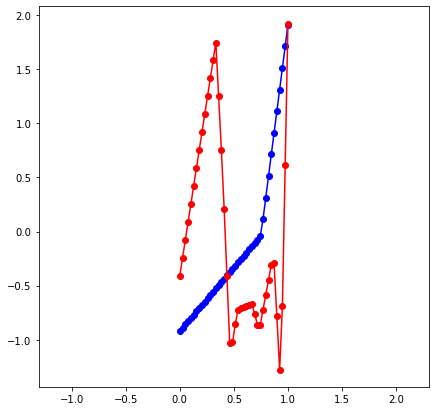

In [6]:
ax = plot_curve(curve_a, "o-b", add_origin=False)
plot_curve(curve_b, "o-r", ax=ax, add_origin=False)
plt.axis("equal")
plt.show()

In [7]:
curves_r2 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=2, k_sampling_points=k_sampling_points, equip=False
)

curve_a = curves_r2.projection(curve_a)
curve_b = curves_r2.projection(curve_b)

# curve_a = curves_r2.normalize(curve_a)
# curve_b = curves_r2.normalize(curve_b)

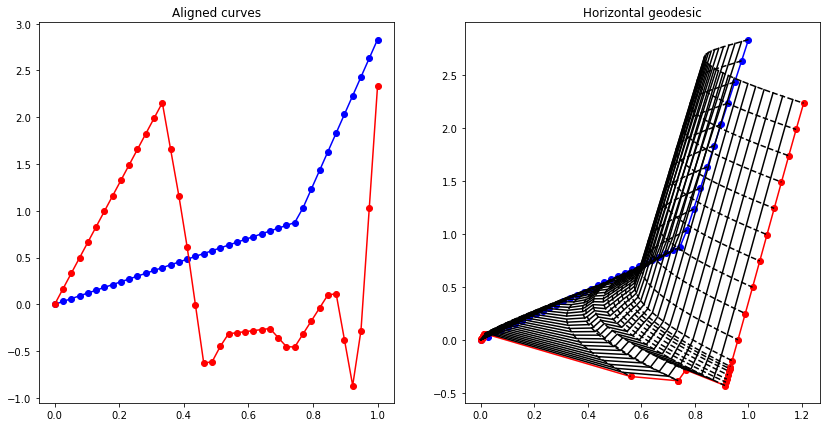

In [8]:
curves_r2.equip_with_metric(SRVMetric) #
curves_r2.equip_with_group_action("rotations and reparametrizations")
curves_r2.equip_with_quotient_structure()

curve_b_aligned = curves_r2.fiber_bundle.align(curve_b, curve_a)

hgeod_fun = curves_r2.quotient.metric.geodesic(curve_a, curve_b)

n_times = 30
times = gs.linspace(0.0, 1.0, n_times)
hgeod = hgeod_fun(times)

def plot_geodesic(geod, translation=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    geod = insert_zeros(geod, axis=-2)

    if translation is not None:
        geod = geod + gs.expand_dims(translation, axis=-2)

    ax.plot(geod[0, :, 0], geod[0, :, 1], "o-b")
    ax.plot(geod[-1, :, 0], geod[-1, :, 1], "o-r")

    for i in range(1, n_times - 1):
        ax.plot(geod[i, :, 0], geod[i, :, 1], "k")

    for j in range(k_sampling_points):
        ax.plot(geod[:, j, 0], geod[:, j, 1], "--k")

    return ax

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
plot_curve(curve_a, "o-b", ax=ax1)
plot_curve(curve_b, "o-r", ax=ax1)
ax1.set_title("Aligned curves")

plot_geodesic(hgeod, ax=ax2)
ax2.set_title("Horizontal geodesic")
plt.show()

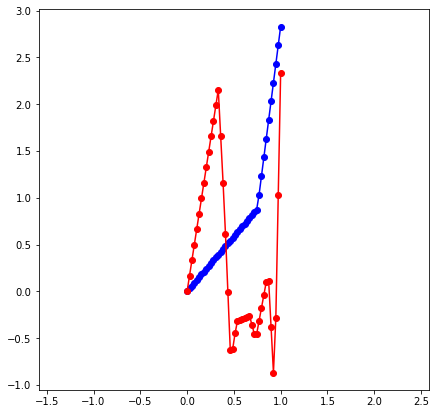

In [9]:
curves_r2 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=2, k_sampling_points=k_sampling_points, equip=False
)

curve_a0 = curves_r2.projection(curve_a)
curve_b0 = curves_r2.projection(curve_b)

ax = plot_curve(curve_a0, "o-b")
plot_curve(curve_b0, "o-r", ax=ax)
plt.axis("equal")
plt.show()

In [10]:
curves_r2.equip_with_metric(SRVMetric)

curves_r2.metric.dist(point_a=curve_a0, point_b=curve_b0)

3.072485480500244

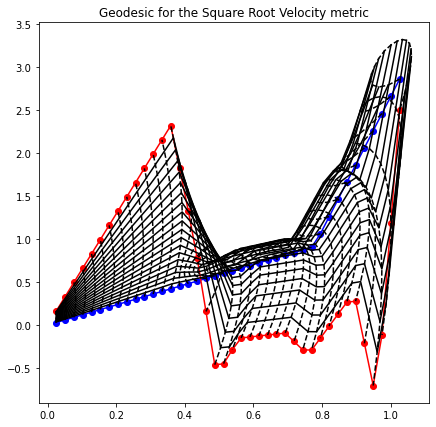

In [11]:
geod_fun = curves_r2.metric.geodesic(curve_a0, curve_b0)

n_times = 20
times = gs.linspace(0.0, 1.0, n_times)
geod = geod_fun(times)
translation = gs.linspace(curve_a[0], curve_b[0], n_times)

plot_geodesic(geod, translation)
plt.title("Geodesic for the Square Root Velocity metric")
plt.show()

In [12]:
curve_a_resampled = curve_a0
curve_b_resampled = curve_b0

curve_a0_resampled = curves_r2.projection(curve_a_resampled)
curve_b0_resampled = curves_r2.projection(curve_b_resampled)

curves_r2.metric.dist(curve_a0_resampled, curve_b0_resampled)

3.072485480500244

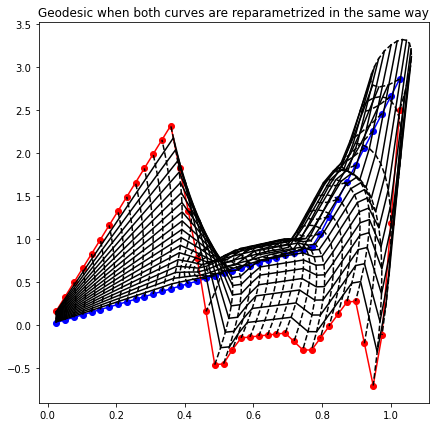

In [13]:
geod_fun_1 = curves_r2.metric.geodesic(curve_a0_resampled, curve_b0_resampled)
geod_1 = geod_fun_1(times)

plot_geodesic(geod_1, translation=translation)
plt.title("Geodesic when both curves are reparametrized in the same way")
plt.show()

In [14]:
####### Plot Graph #######
# plt.figure(figsize=(16,16))
# nx.draw(graphs['BT.1.A.'], pos=nx.kamada_kawai_layout(graphs['BT.1.A.']), with_labels=True, font_weight='bold')
# plt.show()

In [15]:
nodes_list = random_graph_sequence(graphs['BT.1.A.'])

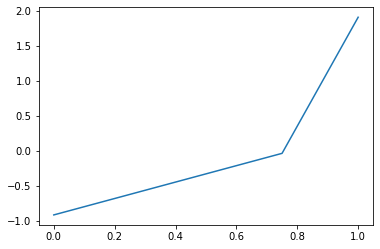

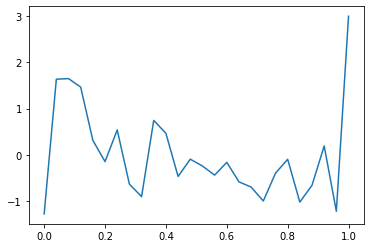

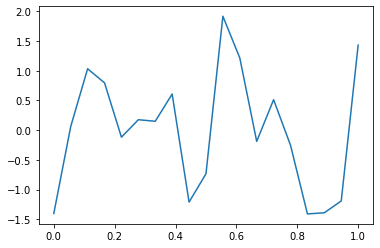

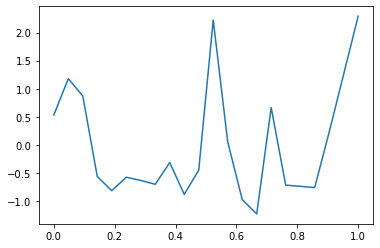

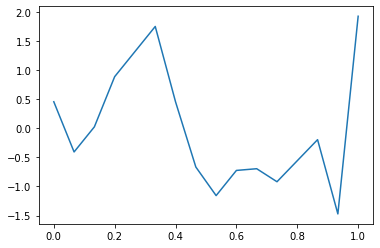

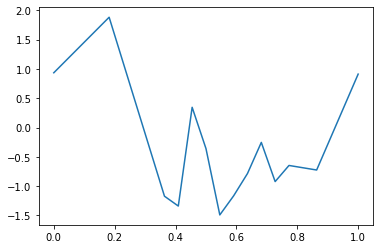

In [16]:
for id, g in graphs.items():
    nodes_list = random_graph_sequence(g)
    plot_function(nodes_list, graphs, id, "surface")
    plt.show()